In [26]:
import pandas as pd
import re

# Load your dataset
df = pd.read_excel('StudentAddresses-2016-2024.xlsx')

# Function to clean zip codes
def clean_zip_code(zip_code):
    if pd.isnull(zip_code):  # Check for missing values
        return None
    
    # Convert zip code to string to handle numeric and string inputs
    zip_code = str(zip_code).strip()
    
    #Check for zip codes with an extra four digits (e.g., 12345-6789)
    if re.match(r'^\d{5}-\d{4}$', zip_code):
        return zip_code[:5]  # Keep only the first 5 digits
    
    # If zip code is 4 digits, add leading zero
    if len(zip_code) == 4:
        return '0' + zip_code
    
    # If it's already 5 digits, return as is
    if len(zip_code) == 5:
        return zip_code
    
    return None  # For invalid formats, return None or handle as needed

# Apply the function to clean the zip code column
df['Cleaned Zip'] = df['6e. zip'].apply(clean_zip_code)

# Save the cleaned dataset
df.to_excel('cleaned_student_addresses_2016_2024.xlsx', index=False)


In [2]:
import pandas as pd
from geopy.geocoders import Nominatim
import time

# Load the dataset
df = pd.read_excel('StudentAddresses-2016-2024.xlsx')

# Initialize the geocoder
geolocator = Nominatim(user_agent="student_housing_app")

# Function to geocode addresses
def geocode_address(row):
    try:
        location = geolocator.geocode(f"{row['Street Name']}, Boston, MA {row['Zip']}")
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        return pd.Series([None, None])

# Apply the geocode function to the dataset
df[['Latitude', 'Longitude']] = df.apply(geocode_address, axis=1)

# Sleep to avoid hitting the geocoding API rate limits
time.sleep(1)

# Save the geocoded dataset
df.to_excel('geocoded_student_addresses.xlsx', index=False)


In [3]:
import pandas as pd
from geopy.geocoders import Nominatim
import time

# Load the dataset
df = pd.read_excel('cleaned_student_addresses_2016_2024.xlsx')

# Ensure ZIP code is a string and 5 digits long
df['6e. zip'] = df['6e. zip'].astype(str).str.zfill(5)

# Get unique ZIP codes
unique_zips = df['6e. zip'].unique()
print(unique_zips)

['02134' '02215' '02120' ... '00220' '01902' '01760']


In [5]:
len(unique_zips)

2515

In [8]:
import pandas as pd
from geopy.geocoders import Nominatim
import time

# Load the dataset
df = pd.read_excel('StudentAddresses-2016-2024.xlsx')

# Ensure ZIP code is a string, remove any extra 4-digit part after the dash, and handle 4-digit zip codes by adding a 0 in front
def clean_zip(zip_code):
    zip_code = str(zip_code).split('-')[0]  # Take only the first part before the dash if extended format
    return zip_code.zfill(5)  # Ensure 5 digits by adding leading zeros if necessary

# Apply the cleaning function to the ZIP code column
df['6e. zip'] = df['6e. zip'].apply(clean_zip)

# Get unique ZIP codes
unique_zips = df['6e. zip'].unique()

# Initialize the geocoder
geolocator = Nominatim(user_agent="student_housing_app")

# Dictionary to store geocoded results for ZIP codes
zip_geocoded = {}

# Geocode each unique ZIP code
for zip_code in unique_zips:
    try:
        location = geolocator.geocode(f"{zip_code}, Boston, MA")
        if location:
            zip_geocoded[zip_code] = (location.latitude, location.longitude)
        else:
            zip_geocoded[zip_code] = (None, None)
        time.sleep(1)  # Sleep to respect API rate limits
    except Exception as e:
        zip_geocoded[zip_code] = (None, None)
        print(f"Error geocoding {zip_code}: {e}")

# Create new columns for latitude and longitude by mapping the geocoded results
df['Latitude'] = df['6e. zip'].map(lambda zip_code: zip_geocoded[zip_code][0])
df['Longitude'] = df['6e. zip'].map(lambda zip_code: zip_geocoded[zip_code][1])

# Save the geocoded dataset
df.to_excel('geocoded_student_addresses.xlsx', index=False)

print("Geocoding completed and saved.")


Geocoding completed and saved.


In [12]:
import os
import fiona

# Setting the environment variable to attempt restoring SHX
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

# Re-run the code to load the shapefile
districts_gdf = gpd.read_file('CityCouncilDistricts_2024.shp')


In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load student housing data (with Latitude and Longitude)
student_housing_df = pd.read_excel('geocoded_student_addresses.xlsx')

# Ensure the correct geometry creation
geometry = [Point(xy) for xy in zip(student_housing_df['Longitude'], student_housing_df['Latitude'])]
gdf_students = gpd.GeoDataFrame(student_housing_df, geometry=geometry, crs="EPSG:4326")  # CRS for WGS 84

# Load the shapefile of the city council districts
districts_gdf = gpd.read_file('CityCouncilDistricts_2024.shp')

# Reproject the districts_gdf to match the CRS of the student addresses (EPSG:4326)
districts_gdf = districts_gdf.to_crs(gdf_students.crs)

# Perform a spatial join to map student addresses to districts
students_in_districts = gpd.sjoin(gdf_students, districts_gdf, how="left", predicate="intersects")

# Save the result to a new file
students_in_districts.to_excel('students_with_districts.xlsx', index=False)

print("Spatial join and saving completed.")


Spatial join and saving completed.


In [4]:
# Group by district and year to count the number of students per district
students_per_district = students_in_districts.groupby(['DISTRICT', 'year']).size().reset_index(name='Num_Students')

# Calculate the total housing in each district (you may need external data for total housing)
# Assuming you have this information in a dataset (you can use a placeholder for now):
total_housing_per_district = students_in_districts.groupby(['DISTRICT']).size().reset_index(name='Total_Housing')

# Calculate the percentage of student housing
students_per_district = pd.merge(students_per_district, total_housing_per_district, on='DISTRICT')
students_per_district['Student_Housing_Percentage'] = (students_per_district['Num_Students'] / students_per_district['Total_Housing']) * 100

# Save the results
students_per_district.to_excel('student_housing_percentage_by_district.xlsx', index=False)


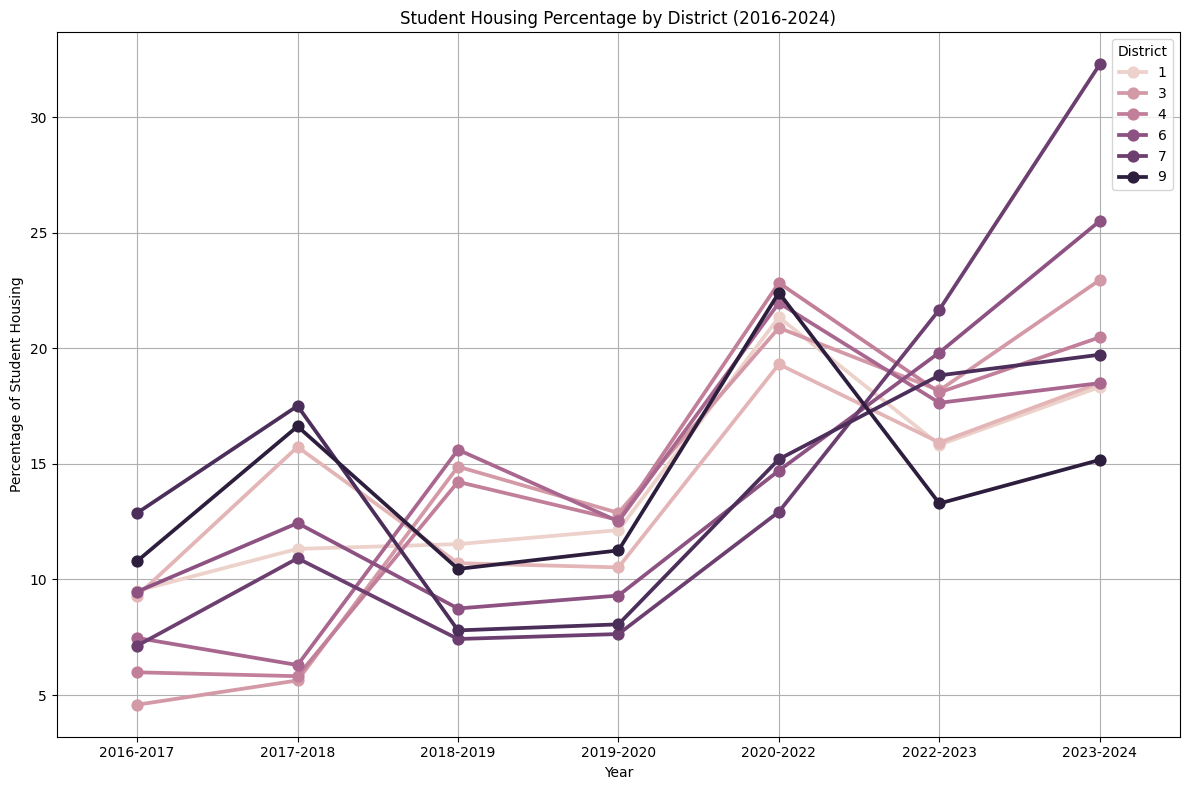

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel('student_housing_percentage_by_district.xlsx')

# Set up the plot size
plt.figure(figsize=(12, 8))

# Create the line plot with year on the X-axis and district as the legend
sns.pointplot(x='year', y='Student_Housing_Percentage', hue='DISTRICT', data=df, marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage of Student Housing')
plt.title('Student Housing Percentage by District (2016-2024)')

# Show the legend for districts
plt.legend(title='District')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


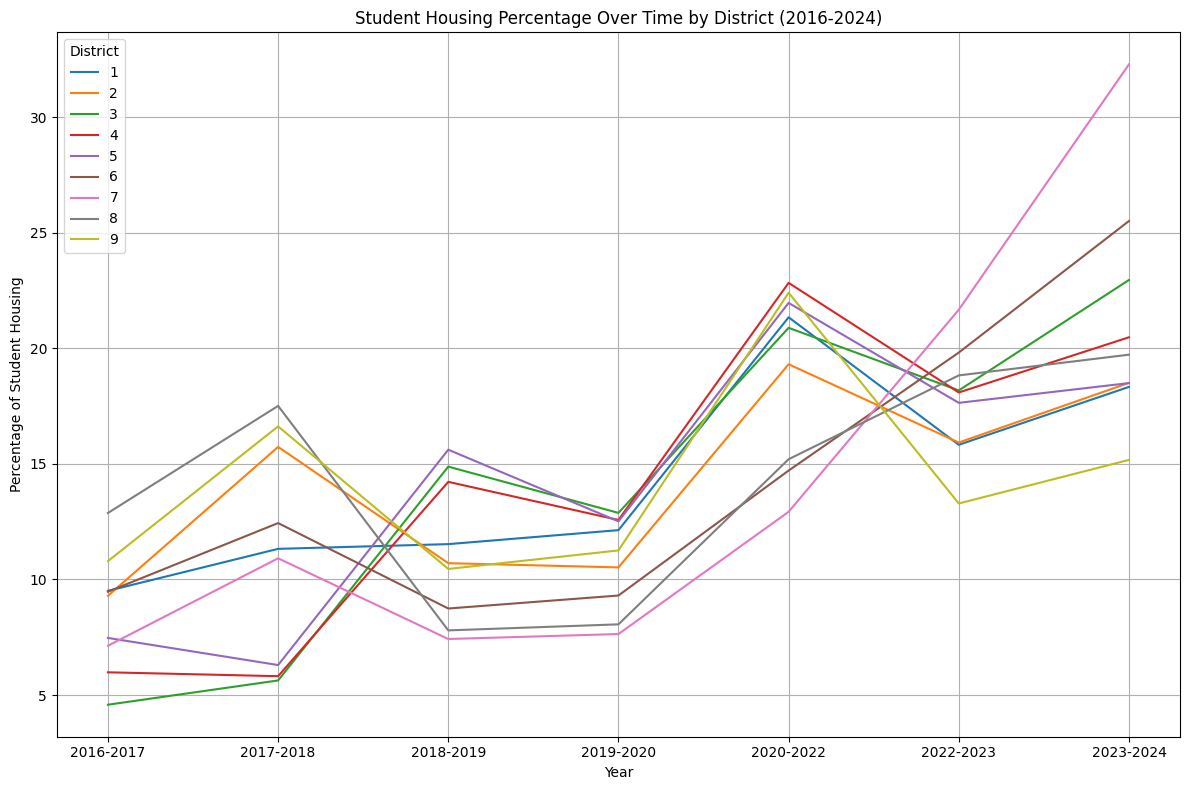

In [25]:
plt.figure(figsize=(12, 8))

# Plot each district as a separate line to see percentage change over time
for district in df['DISTRICT'].unique():
    district_data = df[df['DISTRICT'] == district]
    plt.plot(district_data['year'], district_data['Student_Housing_Percentage'], label=district)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage of Student Housing')
plt.title('Student Housing Percentage Over Time by District (2016-2024)')
plt.legend(title='District')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
import geopandas as gpd
import folium

# Load the shapefile (district boundaries)
districts_gdf = gpd.read_file('CityCouncilDistricts_2024.shp')

# Load the student housing percentage data
df = pd.read_excel('student_housing_percentage_by_district.xlsx')

# Merge the percentage data with the shapefile data
districts_gdf = districts_gdf.merge(df, on='DISTRICT')

# Initialize a folium map
m = folium.Map(location=[42.3601, -71.0589], zoom_start=11)

# Add a choropleth layer to visualize student housing percentage by district
folium.Choropleth(
    geo_data=districts_gdf,
    name='choropleth',
    data=districts_gdf,
    columns=['DISTRICT', 'Student_Housing_Percentage'],
    key_on='feature.properties.District',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Student Housing Percentage'
).add_to(m)

# Display the map
m.save('student_housing_percentage_map.html')


ModuleNotFoundError: No module named 'folium'